In [1]:
source('../../source/basic.r')

source('../validataion.r')


Warning message:
“no function found corresponding to methods exports from ‘BSgenome’ for: ‘releaseName’”


In [2]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(Signac)
    library(Seurat)
    library(GenomeInfoDb)
    library(EnsDb.Hsapiens.v86 )# hg38
   # library(EnsDb.Hsapiens.v75) #hg19
    library(ggplot2)
    library(patchwork)
    library(data.table)
    library(Matrix)
    set.seed(1234)
})

In [183]:
sampleColors <- RColorBrewer::brewer.pal(12,"Paired")

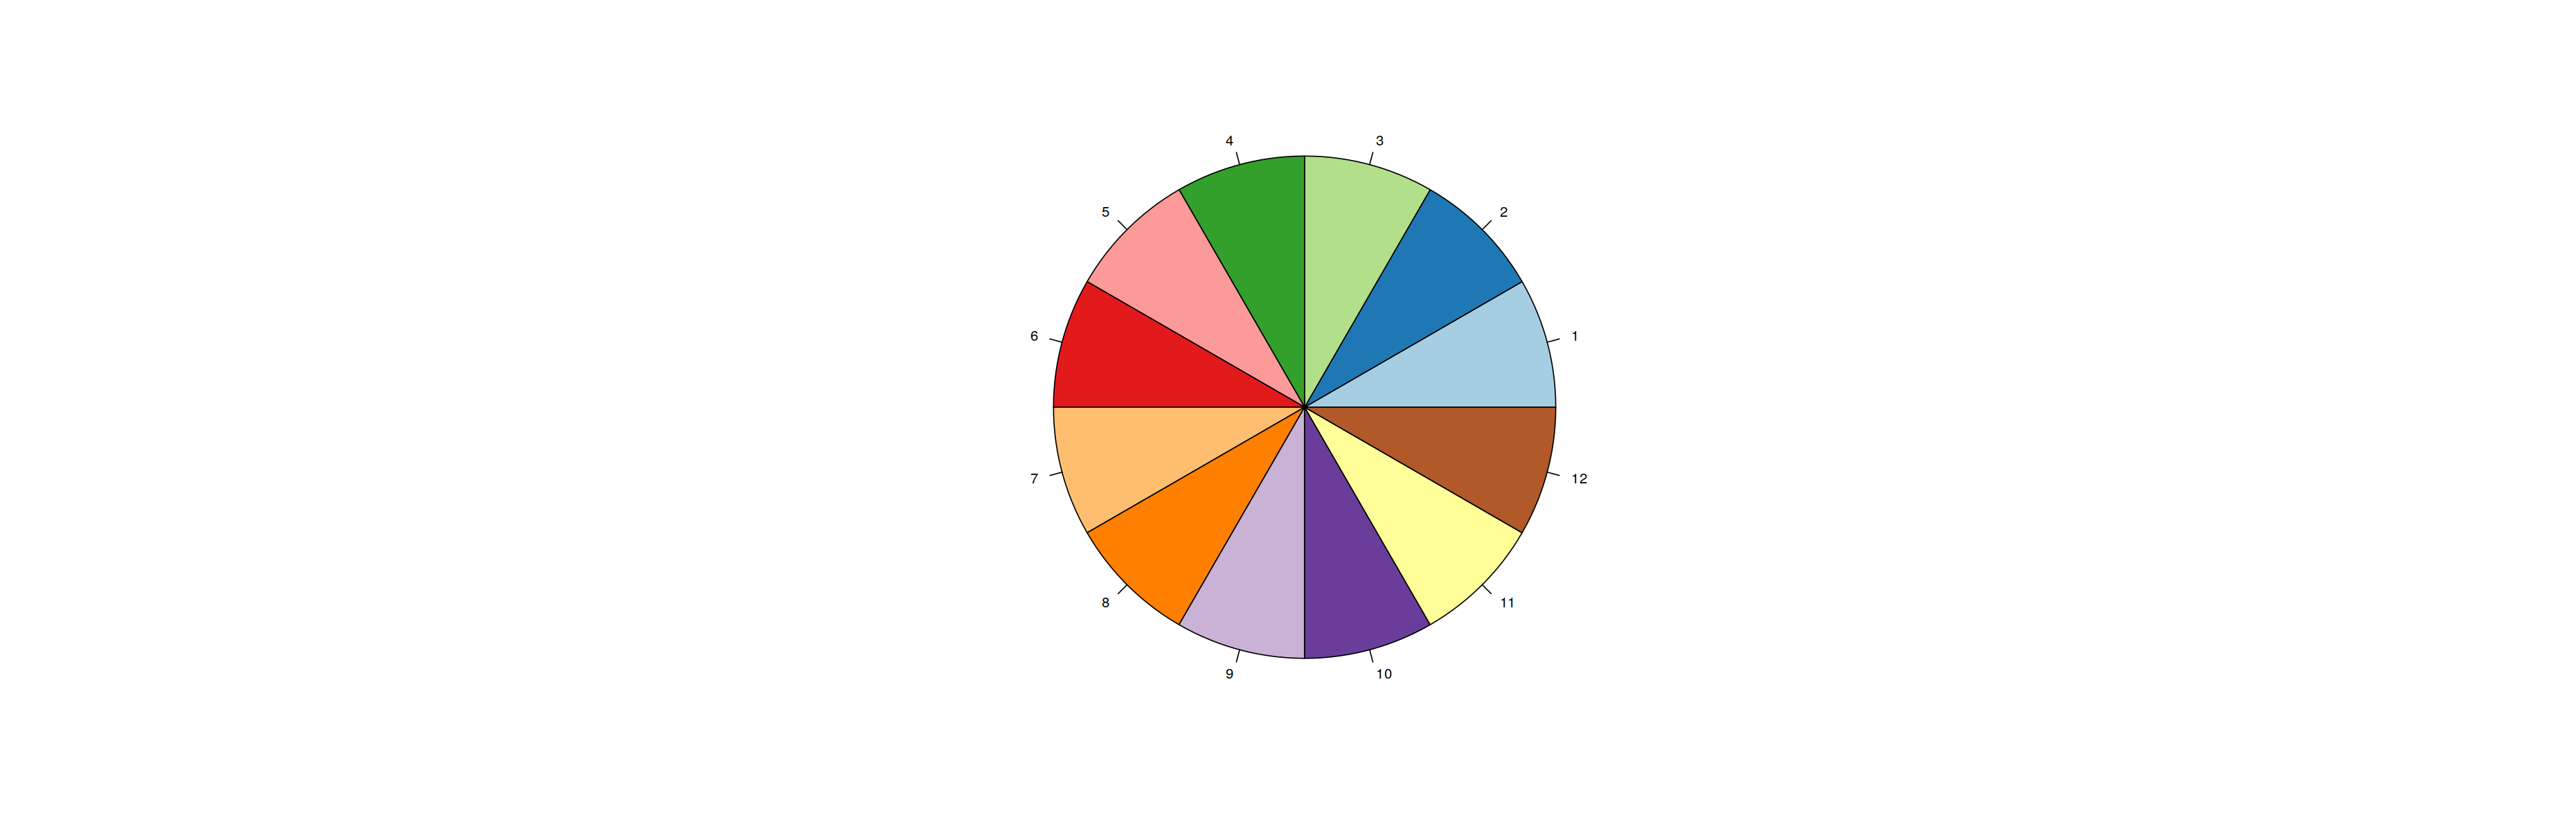

In [184]:
pie(rep(1,12), col=sampleColors) 

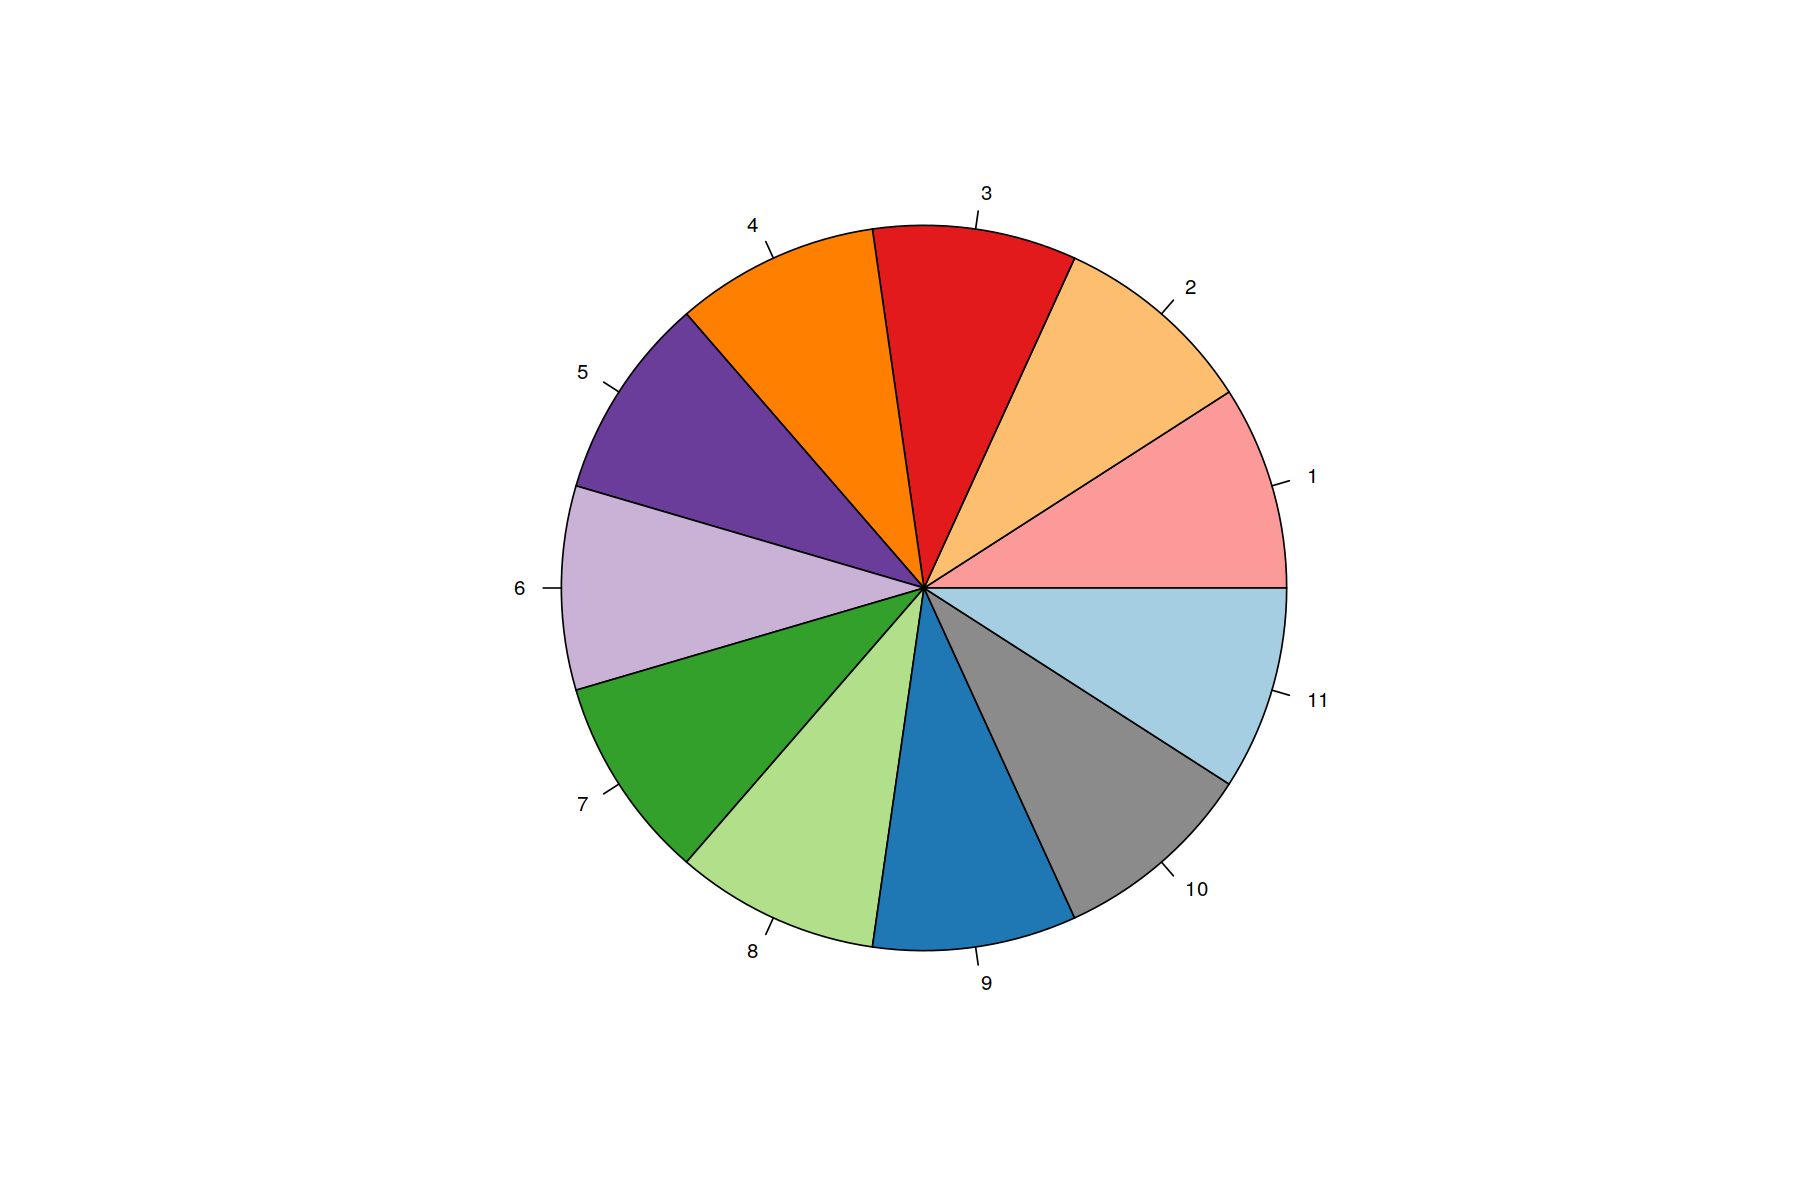

In [192]:
sampleColors <- RColorBrewer::brewer.pal(11,"Paired")
sampleColors[11] <- "#8c8b8b"


# Color patient tumors to resemble the cancer ribbon color 
sampleColors <- c(sampleColors[5],sampleColors[7],sampleColors[6],sampleColors[8],sampleColors[10],sampleColors[9],sampleColors[4],sampleColors[3],sampleColors[2],sampleColors[11],sampleColors[1])

pie(rep(1,11), col=sampleColors) 

# cpeak data

## read data

In [5]:
IDs = list.files('data/',pattern = 'gz.mtx')%>%str_extract(('(?<=_).*(?=_ATAC)'))

In [8]:
counts <- readMM("data/all/all_barcodes.mtx") 

In [24]:
counts%>%dim

[1] 1568814   74621

In [11]:
colnames(counts) <- fread('data/all/all_barcodes.txt',header = FALSE)%>%
                    pull(V1)

rownames(counts) <- fread('data/cpeak.bed')%>%mutate(name=paste0(V1,':',V2,'-',V3))%>%pull(name)

In [12]:
counts[1:3,1:3]

3 x 3 sparse Matrix of class "dgTMatrix"
                 3533EL#TCGGGACAGGATTAAC-1 3533EL#ATTGTGGCAAGTAACA-1
chr1:9919-10727                          .                         .
chr1:11043-11422                         .                         .
chr1:13249-13832                         .                         .
                 3533EL#ACCAAACCACCTGAAT-1
chr1:9919-10727                          .
chr1:11043-11422                         .
chr1:13249-13832                         .

In [25]:
metadata <- fread('data/tumor_metadata_Full_Cohort.tsv')

In [26]:
metadata%>%dim

[1] 74621    20

In [28]:
metadata = metadata%>%#dplyr::filter(Sample==sample_name)%>%
        #mutate(Barcode=str_extract(Barcode,'(?<=#).*'))%>%
        column_to_rownames('Barcode')

### subset using metadata

In [31]:
counts.sub <- counts[,intersect(rownames(metadata),colnames(counts))]

In [32]:
metadata.sub <- metadata[intersect(rownames(metadata),colnames(counts)),]

In [33]:
counts.sub%>%dim

[1] 1568814   74621

## build seurat object

In [34]:
chrom_assay <- CreateChromatinAssay(
  counts = counts.sub,
  sep = c(":", "-"),
  genome = 'hg38',
 # fragments = './data/all/all_barcodes.fragments.tsv.gz',
  min.cells = 0,
  min.features = 0
)


Warning message in CreateChromatinAssay(counts = counts.sub, sep = c(":", "-"), :
"Overlapping ranges supplied. Ranges should be non-overlapping."


In [35]:
seurat.object.all <- CreateSeuratObject(
  counts = chrom_assay,
  assay = "peaks",
  meta.data = metadata.sub
)

Warning message:
"Keys should be one or more alphanumeric characters followed by an underscore, setting key from peaks to peaks_"


In [36]:
seurat.object <- subset(seurat.object.all, cells = rownames(metadata.sub))

## Normalize & TF-IDF & SVD
seurat.object <- RunTFIDF(seurat.object)
seurat.object <- FindTopFeatures(seurat.object, min.cutoff = 'q0')
seurat.object <- RunSVD(seurat.object)
p.cor <- DepthCor(seurat.object)

## Clustering &UMAP
suppressMessages({

    seurat.object <- RunUMAP(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindNeighbors(object = seurat.object, reduction = 'lsi', dims = 2:30)
    seurat.object <- FindClusters(object = seurat.object, verbose = FALSE, algorithm = 3)

})
## plot
p.umap.cluster = DimPlot(object = seurat.object, label = TRUE) + theme(aspect.ratio = 1)




Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
"Some features contain 0 total counts"
Running SVD

Scaling cell embeddings

Warning message:
"The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session"


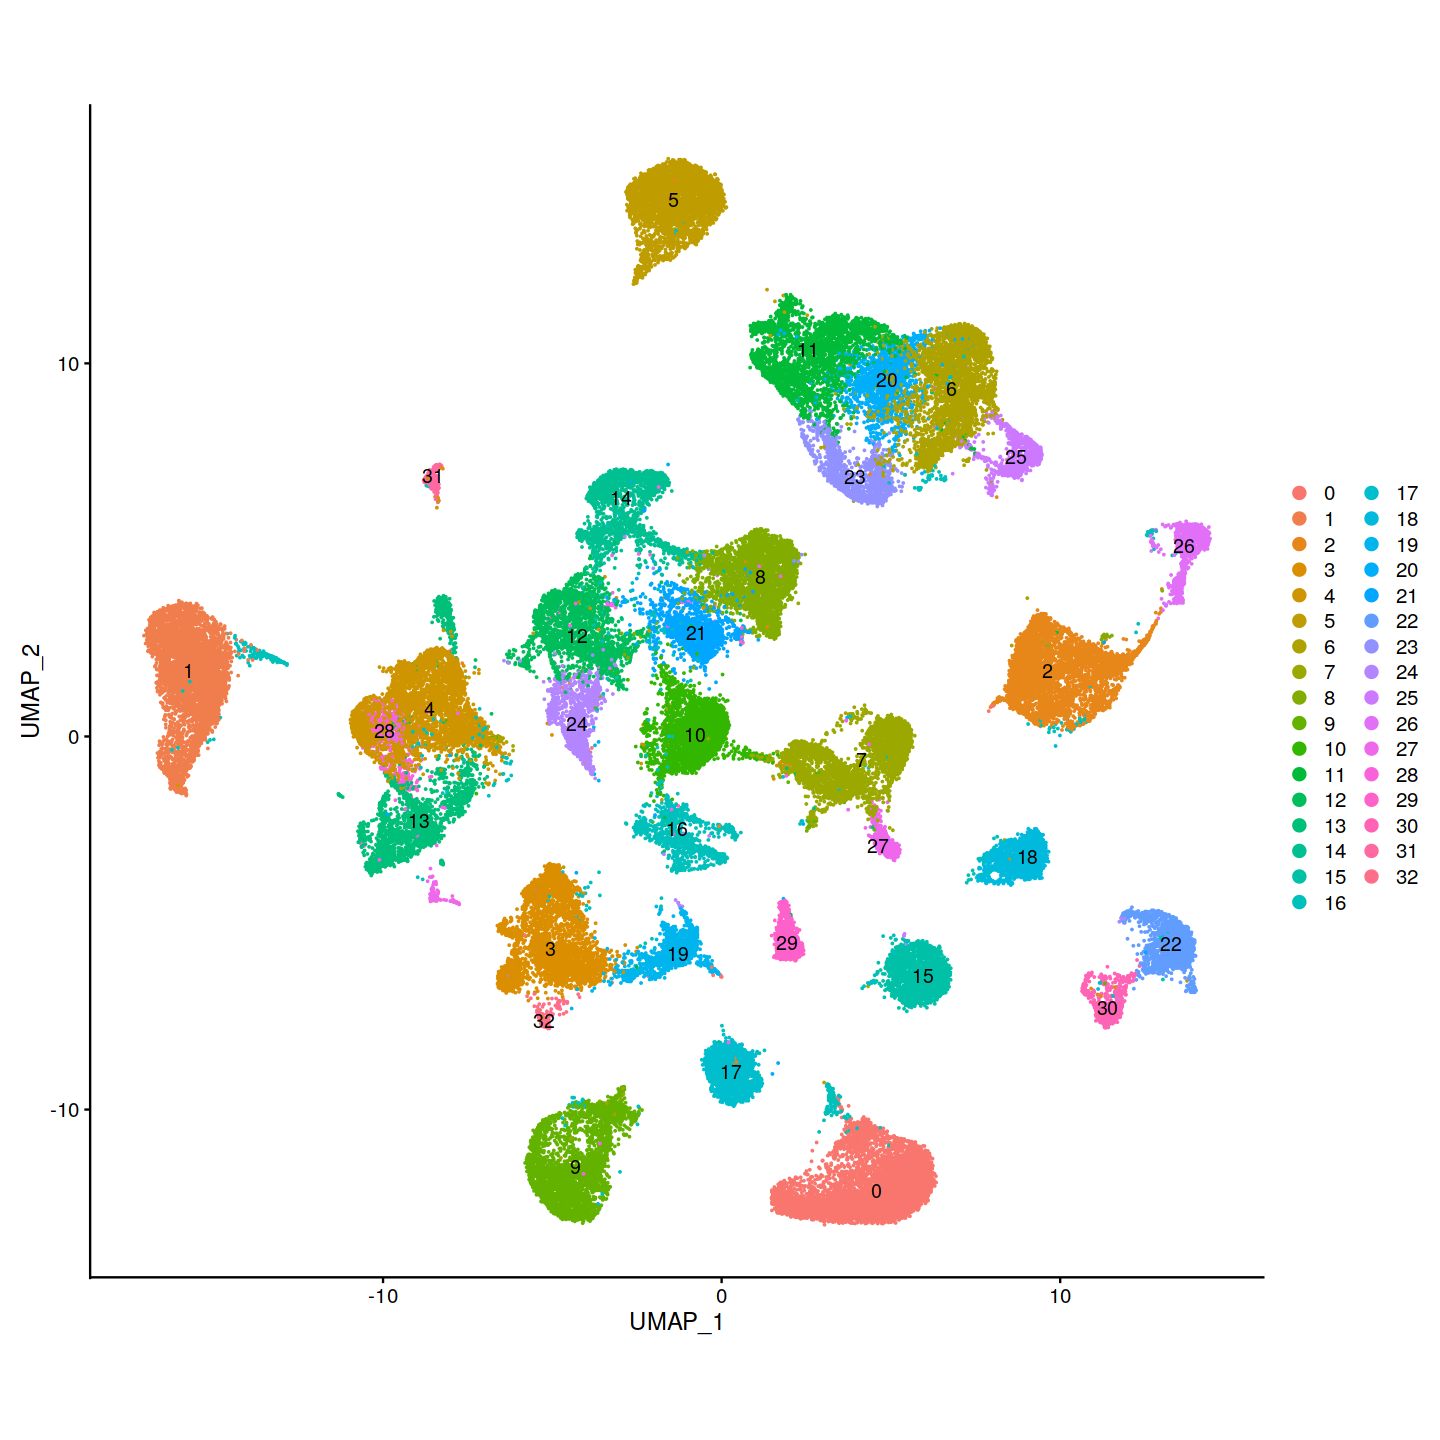

In [37]:
psize(12,12)
p.umap.cluster

In [ ]:
# only plot large clusters
cells.sub <- metadata.sub%>%rownames_to_column('cell')%>%group_by(predictedGroup_ArchR)%>%
            mutate(n=n())%>%ungroup%>% dplyr::filter(n>0)%>%pull(cell)
p.umap.label = DimPlot(object = seurat.object,cells = cells.sub, group.by='predictedGroup_ArchR',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [45]:
p.umap.label2 = DimPlot(object = seurat.object,cells = cells.sub, group.by='Sample',label = TRUE) + 
                theme(aspect.ratio = 1) 

In [187]:
psize(15,10)

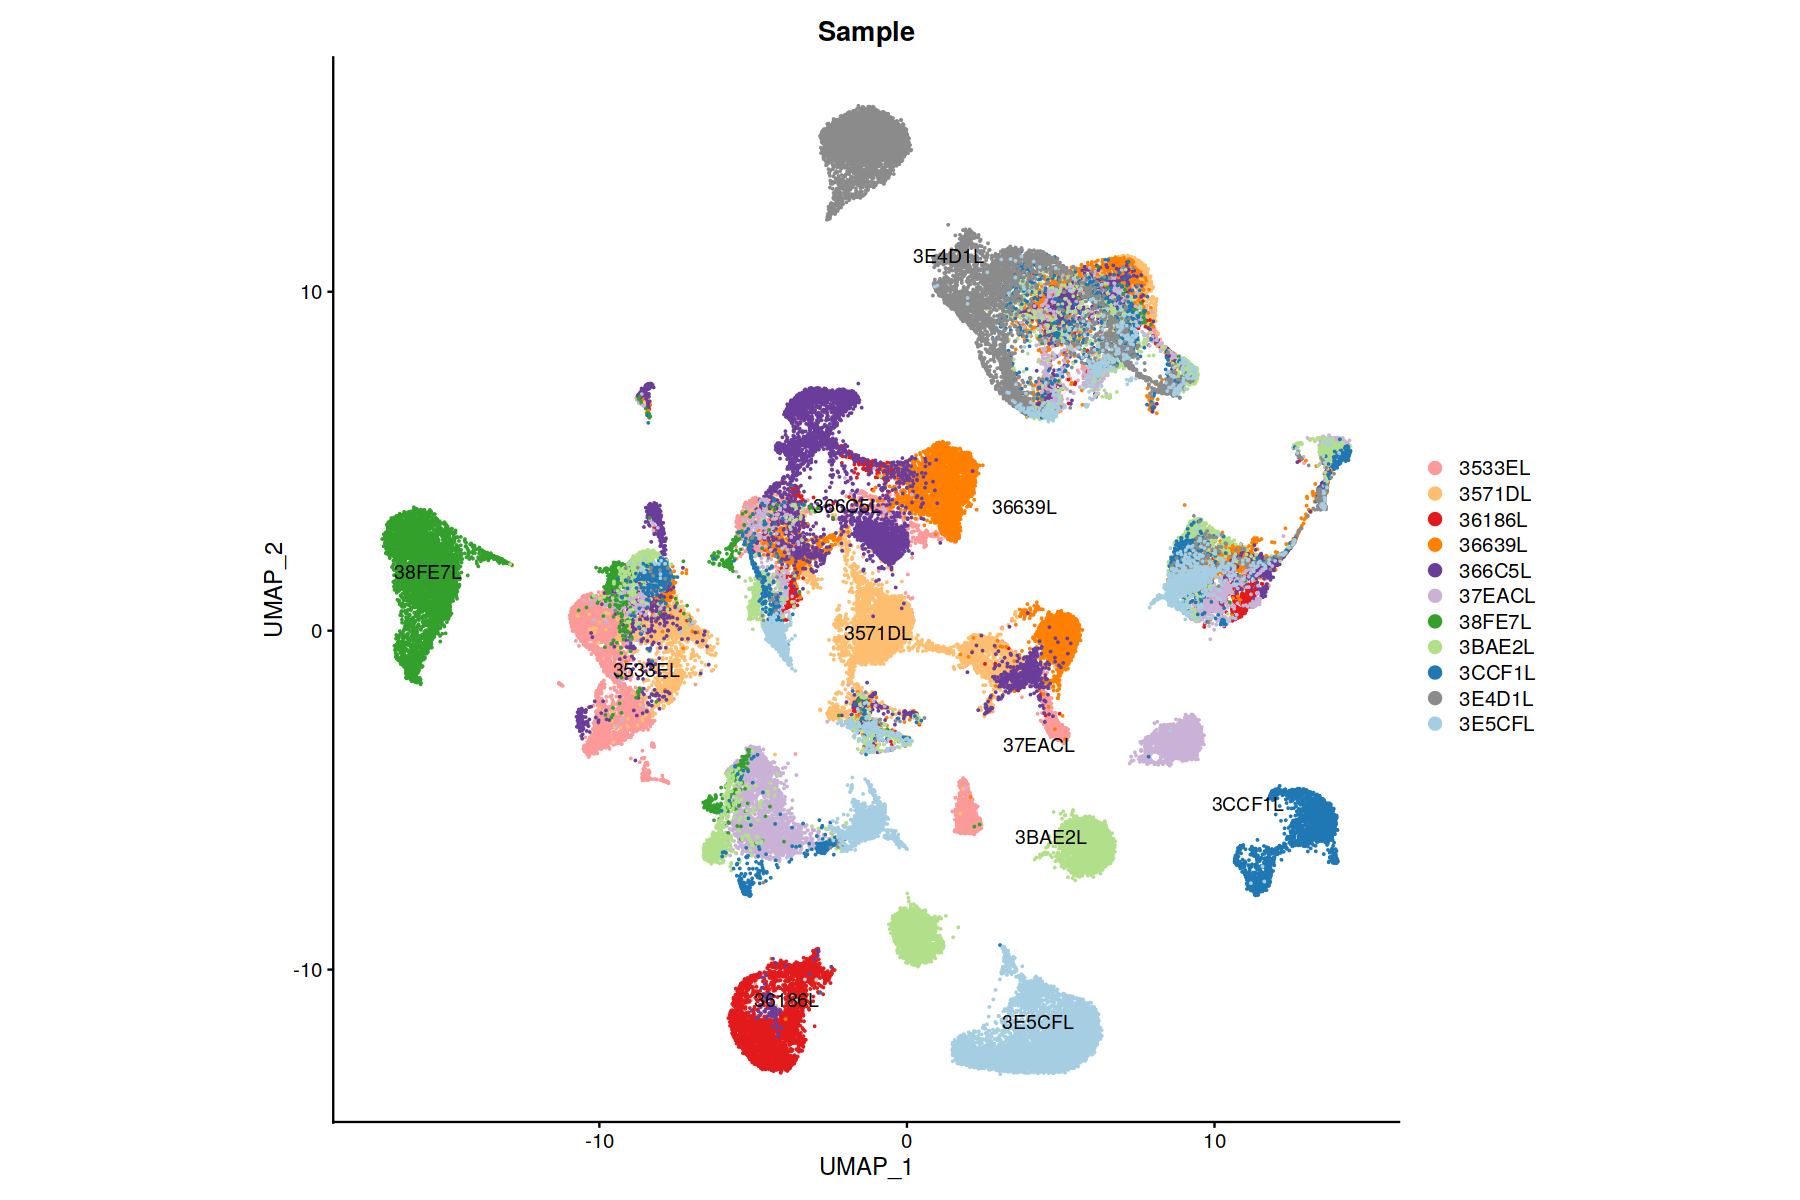

In [188]:
p.umap.label2+scale_color_manual(values=sampleColors)

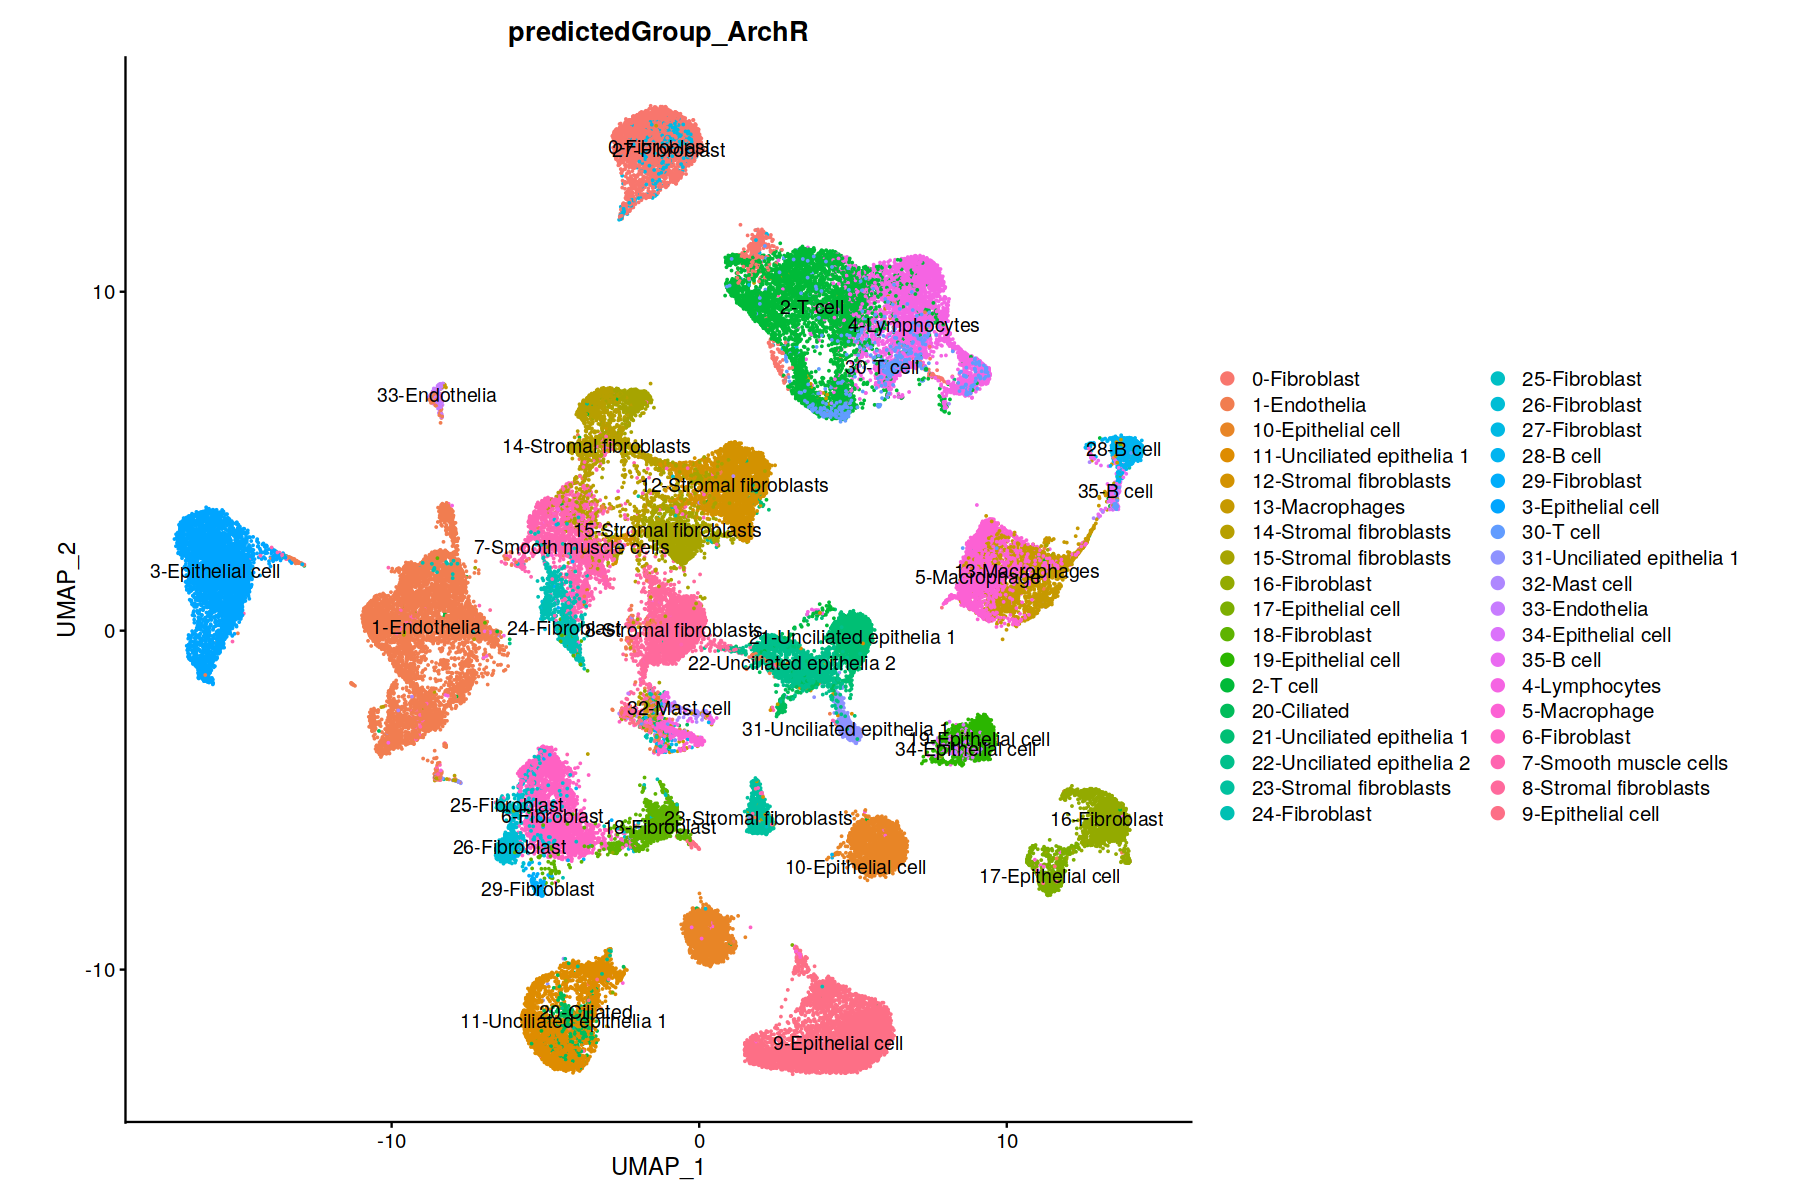

In [190]:
p.umap.label#+scale_color_manual(values=sampleColors)

In [41]:
metadata.rna <- fread('data/tumor_metadata_Full_Cohort_mmc3.tsv')#%>%dplyr::filter(CNV.Pos==TRUE)

In [42]:
    ## add DNA metadata
    metadata.all <- metadata%>%rownames_to_column('ID')%>%
                    left_join(metadata.rna,by=c('predictedCell_ArchR'='Barcode'))%>%column_to_rownames('ID')

    seurat.object@meta.data <-cbind(seurat.object@meta.data,total.cnv=metadata.all$Total_CNVs)
    seurat.object@meta.data <-cbind(seurat.object@meta.data,cnv=metadata.all$CNV.Pos)


    p.umap.cnv = FeaturePlot(object = seurat.object,features='total.cnv',label = FALSE) + theme(aspect.ratio = 1)  
 

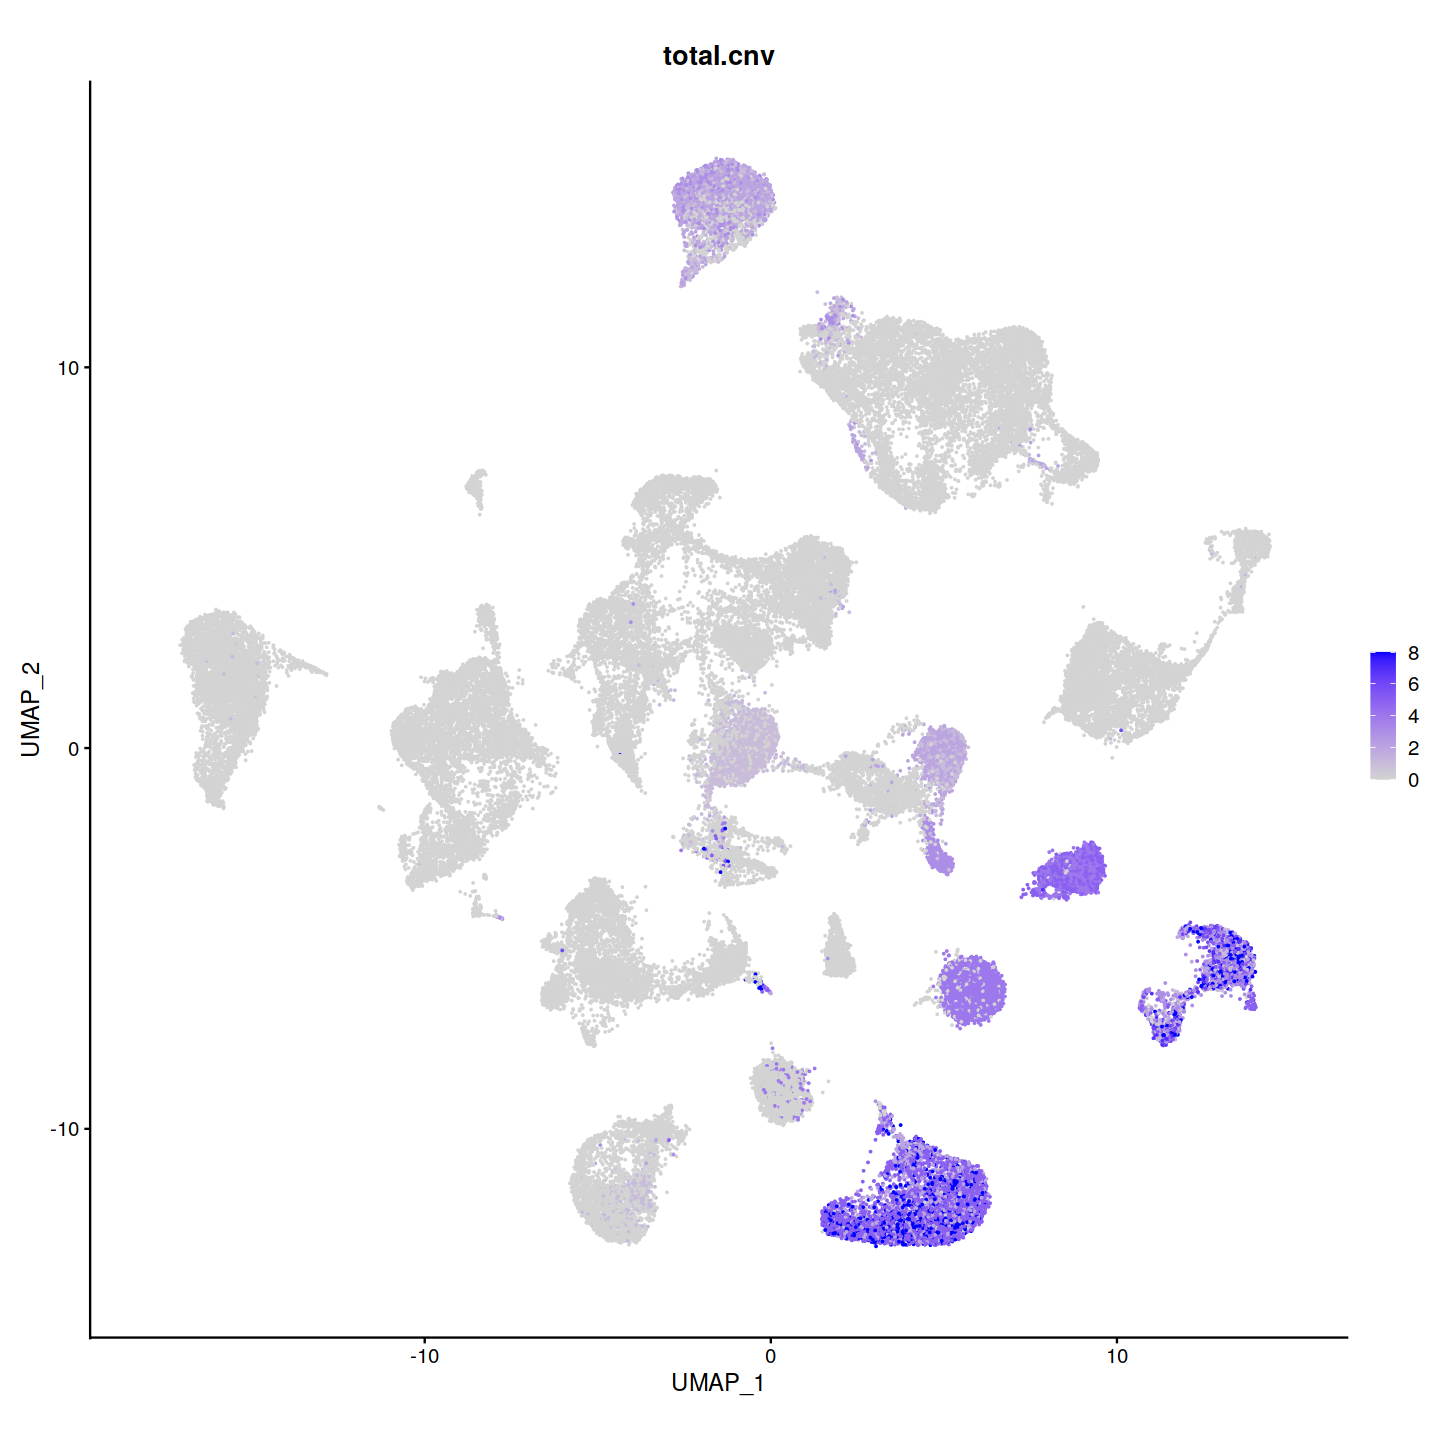

In [43]:
p.umap.cnv

In [54]:
   
    ###################################
    # RNA part

    ## read data
    dir_mtx = list.files('data/rna/all/',pattern = 'mtx')
    dir_barcode = list.files('data/rna/all/',pattern = 'barcodes.txt')
    dir_feature = list.files('data/rna/all/',pattern = 'features')
    counts <- readMM(paste0("data/rna/all/",dir_mtx)) 
    colnames(counts) <- read_table(paste0("data/rna/all/",dir_barcode),col_names  = FALSE,col_types = cols())%>%
                        pull(X1)
    rownames(counts) <- read_table(paste0("data/rna/all/",dir_feature),col_names  = FALSE,col_types = cols())%>%pull(X2)%>%make.unique

In [58]:
colnames(counts)%>%tail

[1] "3E5CFL#TTTGTTGGTCCTTGTC-1" "3E5CFL#TTTGTTGGTCTTTCAT-1"
[3] "3E5CFL#TTTGTTGGTTCCGTTC-1" "3E5CFL#TTTGTTGTCATGAGGG-1"
[5] "3E5CFL#TTTGTTGTCCGTCAAA-1" "3E5CFL#TTTGTTGTCGAGATGG-1"

In [60]:
    ## seurat object
    metadata.rna.sub <- metadata.rna%>%#dplyr::filter(Sample==sample_name)%>%
                        mutate(Barcode=paste0(Sample,'#',gsub('_.$|_..$','',Barcode)))%>%column_to_rownames('Barcode')
    seurat.rna <- CreateSeuratObject(counts = counts, project = "tumor",meta.data = metadata.rna.sub)
    seurat.rna <- subset(seurat.rna, cells = rownames(metadata.rna.sub))
    

In [62]:
    ## normalize  & scale
    seurat.rna <- NormalizeData(seurat.rna, normalization.method = "LogNormalize", scale.factor = 10000)

    seurat.rna <- FindVariableFeatures(seurat.rna, selection.method = "vst", nfeatures = 2000)

    all.genes <- rownames(seurat.rna)
    seurat.rna <- ScaleData(seurat.rna, features = all.genes)

    ## PCA & UMAP & clustering
    seurat.rna <- RunPCA(seurat.rna, features = VariableFeatures(object = seurat.rna))
    seurat.rna <- RunUMAP(seurat.rna, dims = 1:20)
    seurat.rna <- FindNeighbors(seurat.rna, dims = 1:20)
    seurat.rna <- FindClusters(seurat.rna, resolution = 0.5)

    # plots

    # note that you can set `label = TRUE` or use the LabelClusters function to help label
    # individual clusters
    p.umap.cluster.rna <- DimPlot(seurat.rna, reduction = "umap")

    # note that you can set `label = TRUE` or use the LabelClusters function to help label
    # individual clusters
    p.umap.label.rna <- DimPlot(seurat.rna,group.by = 'cell.type', reduction = "umap",label = TRUE)+theme(aspect.ratio = 1)

    p.umap.cnv.rna <- FeaturePlot(object = seurat.rna,features='Total_CNVs',label = FALSE) +theme(aspect.ratio = 1)

10:25:35 Optimization finished

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 75523
Number of edges: 2683210

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9608
Number of communities: 26
Elapsed time: 22 seconds


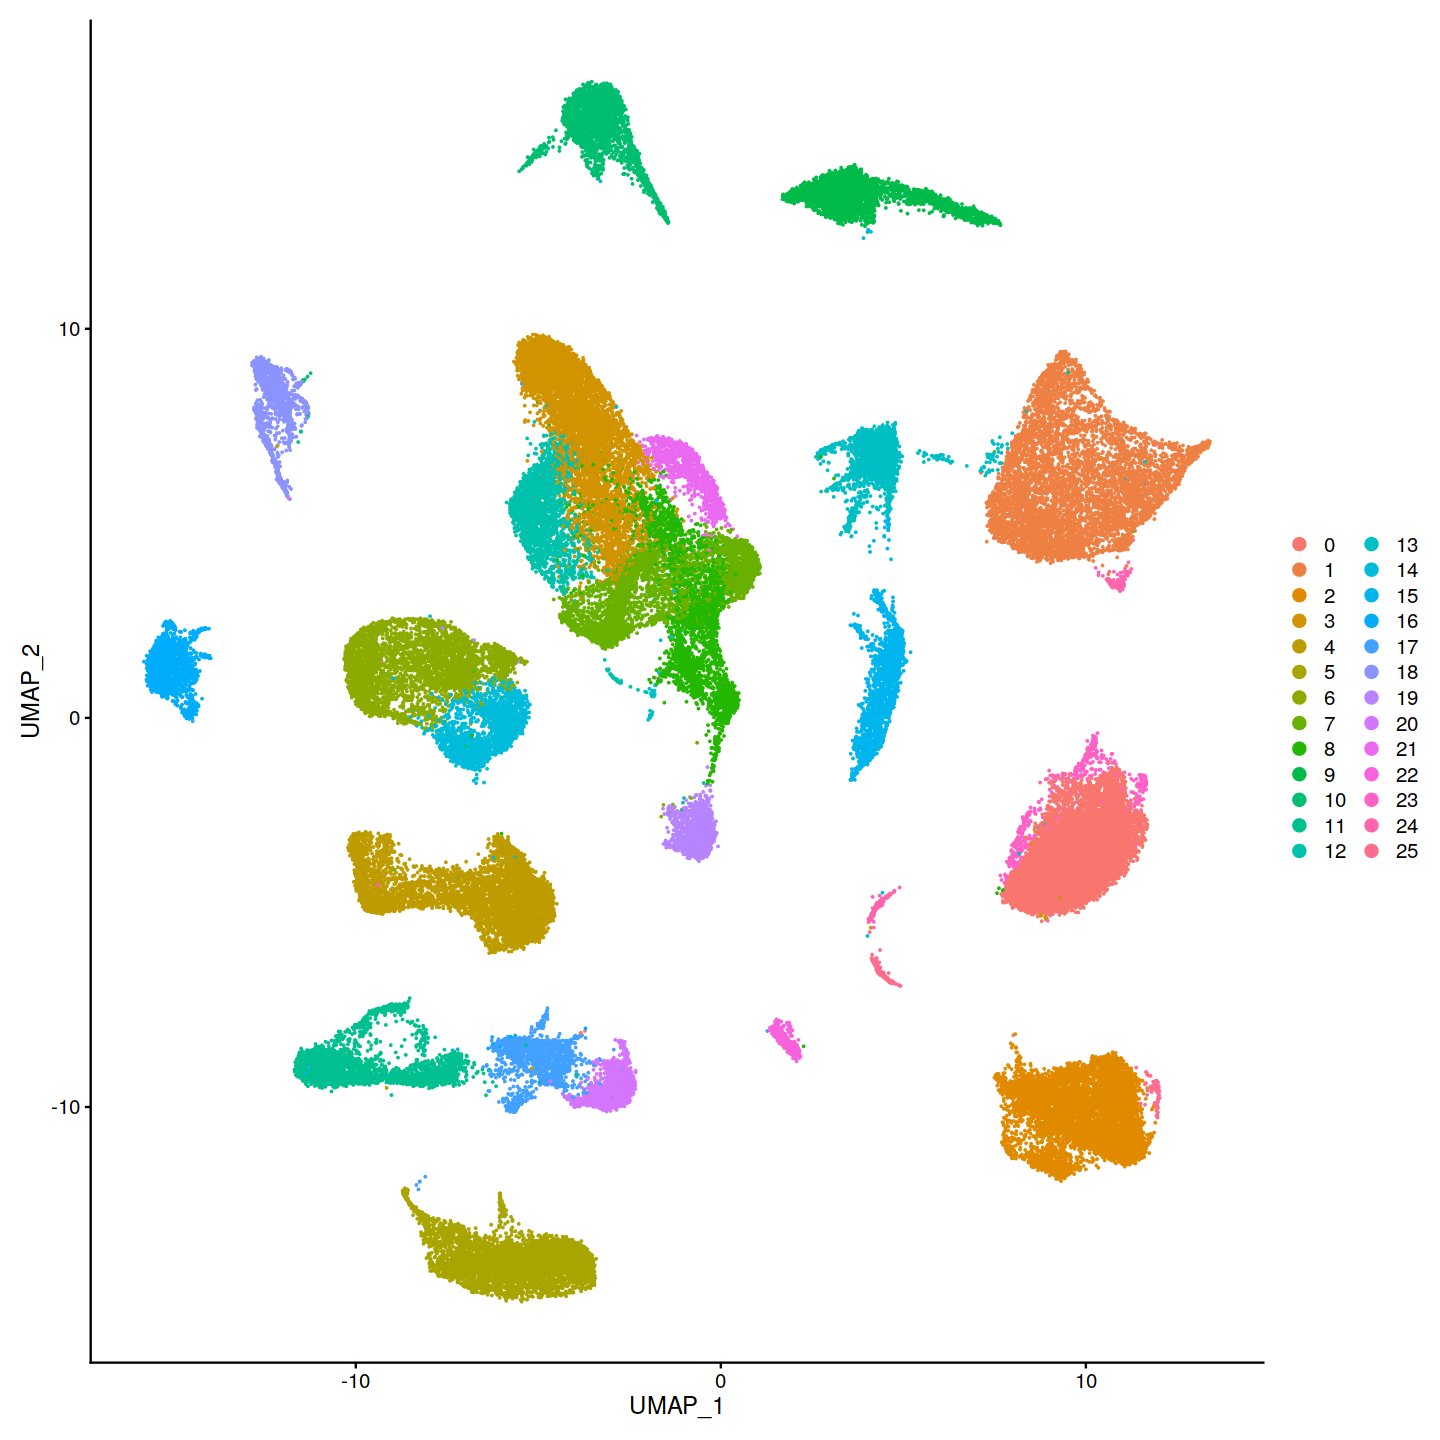

In [63]:
p.umap.cluster.rna

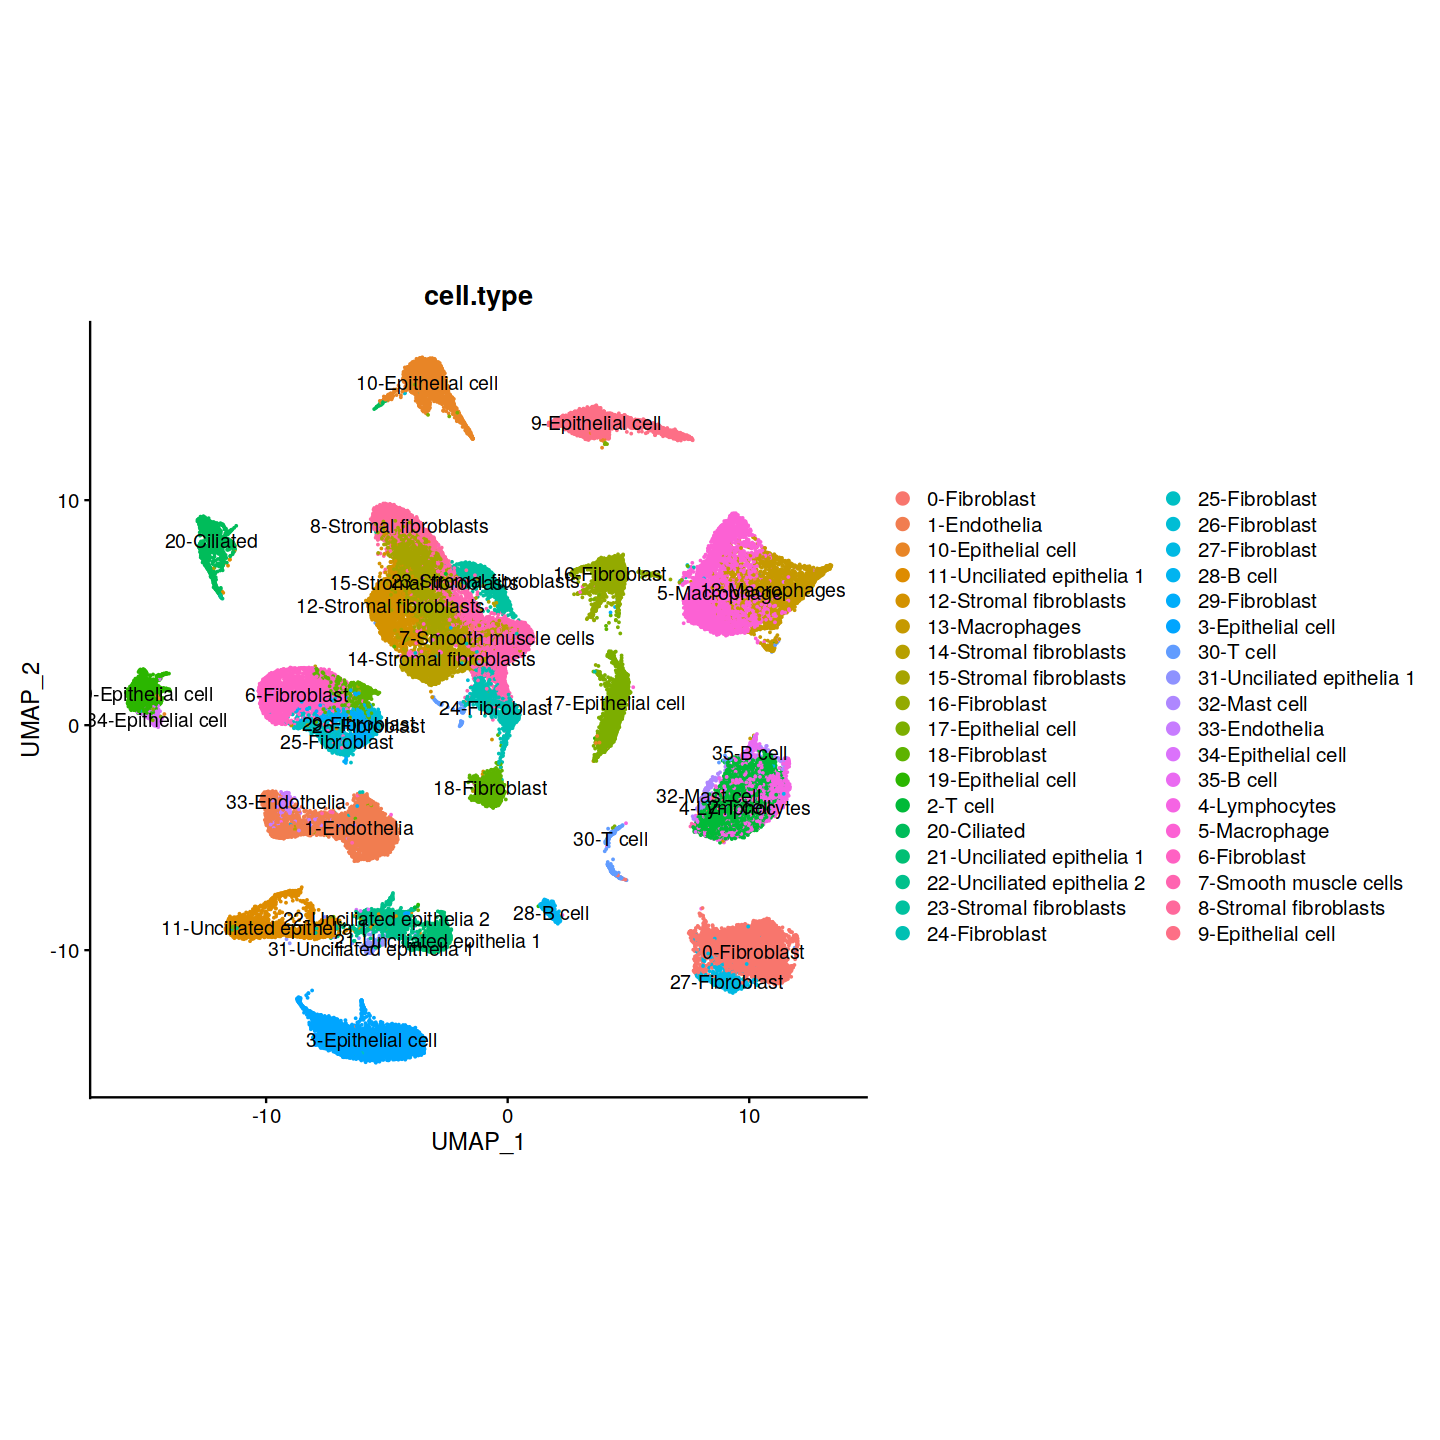

In [64]:
p.umap.label.rna

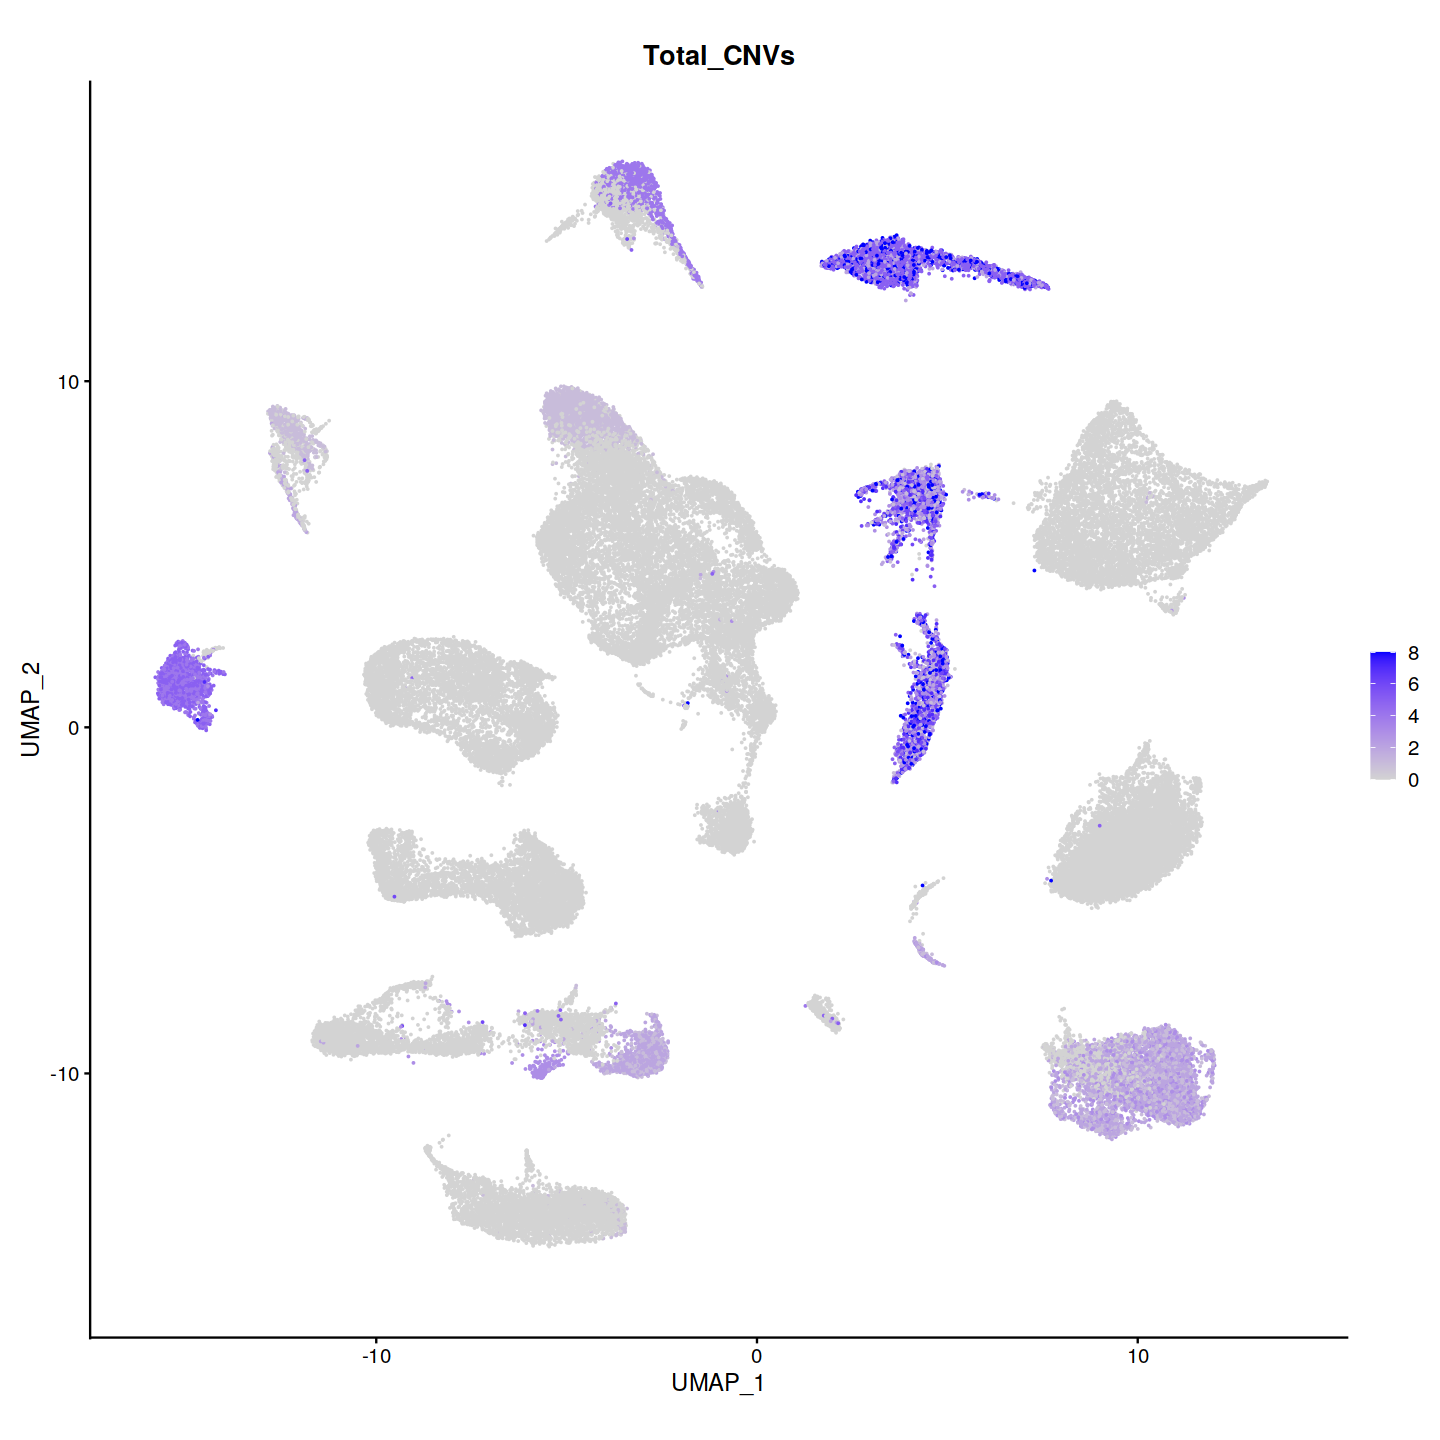

In [65]:
p.umap.cnv.rna

In [ ]:
## add Fragments

In [66]:
fragments <- CreateFragmentObject(
  path = './data/all/all_barcodes.fragments.sort.byBash.tsv.gz',
  cells = colnames(seurat.object),
  validate.fragments = FALSE
)
Fragments(seurat.object) <- fragments

Computing hash



In [67]:
   
    ######################################
    ## ATAC gene activity

    # extract gene annotations from EnsDb
    annotations <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86 )



    # # change to UCSC style since the data was mapped to hg19
    seqlevelsStyle(annotations) <- 'UCSC'

    DefaultAssay(seurat.object) <- "peaks"

    # add the gene information to the object
    Annotation(seurat.object) <- annotations

    gene.activities <- GeneActivity(seurat.object)

    # add the gene activity matrix to the Seurat object as a new assay and normalize it
    seurat.object[['RNA']] <- CreateAssayObject(counts = gene.activities)
    seurat.object <- NormalizeData(
      object = seurat.object,
      assay = 'RNA',
      normalization.method = 'LogNormalize',
      scale.factor = median(seurat.object$nCount_RNA)
    )
 

In [68]:
    ###########################################################
    # link RNA ATAC

    DefaultAssay(seurat.object) <- 'RNA'

    transfer.anchors <- FindTransferAnchors(
      reference = seurat.rna,
      query = seurat.object,
      reduction = 'cca'
    )

    predicted.labels <- TransferData(
      anchorset = transfer.anchors,
      refdata = seurat.rna$cell.type,
      weight.reduction = seurat.object[['lsi']],
      dims = 2:30
    )
    seurat.object <- AddMetaData(object = seurat.object, metadata = predicted.labels)


    plot1 <- DimPlot(
      object = seurat.rna,
      group.by = 'cell.type',
      label = TRUE,
      repel = TRUE) + NoLegend() + ggtitle('scRNA-seq')

    plot2 <- DimPlot(
      object = seurat.object,
      group.by = 'predicted.id',
      label = TRUE,
      repel = TRUE) + NoLegend() + ggtitle('scATAC-seq')

    plot.join <- (plot1+theme(aspect.ratio = 1)) + ((plot2+theme(aspect.ratio = 1)))

    ## results
    res <- list(metadata.sub = metadata.sub,
                seurat.object=list(atac=seurat.object,rna=seurat.rna), 
                plot=list(p.umap.cluster=p.umap.cluster,
                          p.umap.label=p.umap.label,
                          p.umap.cnv=p.umap.cnv,
                          p.umap.cluster.rna=p.umap.cluster.rna,
                          p.umap.label.rna = p.umap.label.rna,
                          p.umap.cnv.rna=p.umap.cnv.rna,
                          p.join = plot.join))
    ## save all plots
    pdf(paste0('plot/','all','.pdf'),height = 6,width=16)
    (res$plot)%>%print
    dev.off()


Running CCA

Merging objects

Finding neighborhoods

Finding anchors

	Found 51365 anchors

Filtering anchors

	Retained 5534 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



$p.umap.cluster

$p.umap.label

$p.umap.cnv

$p.umap.cluster.rna

$p.umap.label.rna

$p.umap.cnv.rna

$p.join



png 
  2

In [69]:
qsave(res,paste0('rds/cpeaks/','all','.qs'))

In [70]:
## save all plots
pdf(paste0('plot/','all.large','.pdf'),height = 10,width=22)
(res$plot)%>%print
dev.off()

$p.umap.cluster

$p.umap.label

$p.umap.cnv

$p.umap.cluster.rna

$p.umap.label.rna

$p.umap.cnv.rna

$p.join



png 
  2

# add other data

In [19]:
library(tidyverse)

In [16]:
tmp = list(`Endometrial Cancer`=c(11,20,21,22,31,19,34),
    `Ovarian Cancer`=c(3,9,10,16,17),
    `GIST` = c(0,27),
    `Fibroblast/Stromal`=c(6,8,12,14,15,18,24,25,26,29),
    `Smooth Muscle`=c(7,23),
    `Endothelial`=c(1,33),
    `NK/T cell`=c(2,4,30),
    `Macrophage`=c(5,13),
    `Mast`=32,
    `B cell`=c(28,35))

tmp = (tmp%>%unlist%>%as.data.frame%>%rename_with(~c('clusterID'))%>%
       rownames_to_column('celltype')%>%mutate(celltype=gsub('[0-99]$','',celltype)))

In [194]:
tmp %>%qsave('metadata_trans.qs')

In [195]:
tmp.meta = seurat.object@meta.data 

In [196]:
metadata.expand <- seurat.object@meta.data%>%rownames_to_column('a')%>%mutate(clusterID=str_extract(predictedGroup_ArchR,'.*(?=-)')%>%as.numeric,
                                clusterType=str_extract(predictedGroup_ArchR,'(?<=-).*'))%>%
                    left_join(tmp,by=c('clusterID'))%>%column_to_rownames('a')

In [203]:
seurat.object@meta.data <- metadata.expand

In [204]:
p.umap.label3 = DimPlot(object = seurat.object,cells = cells.sub, group.by='celltype',label = TRUE) + 
                theme(aspect.ratio = 1) 

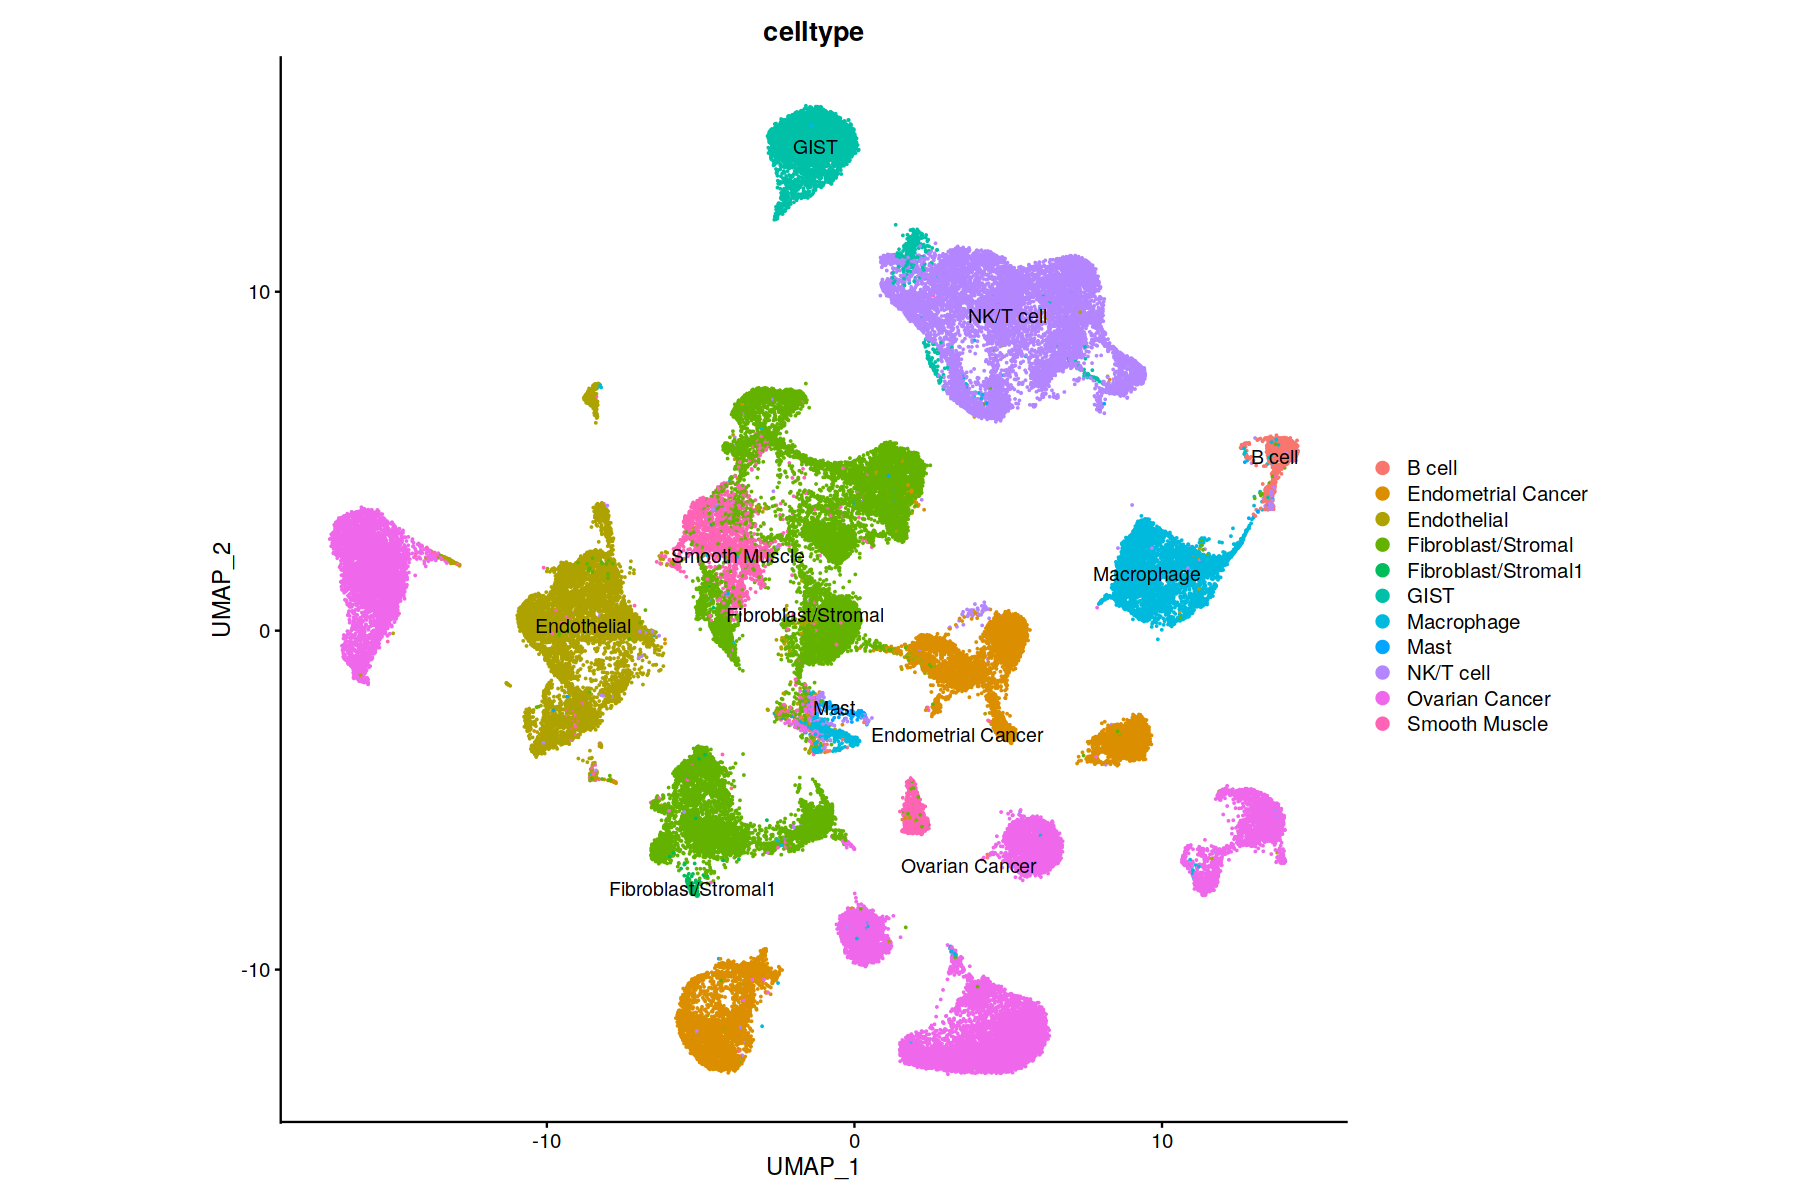

In [205]:
p.umap.label3

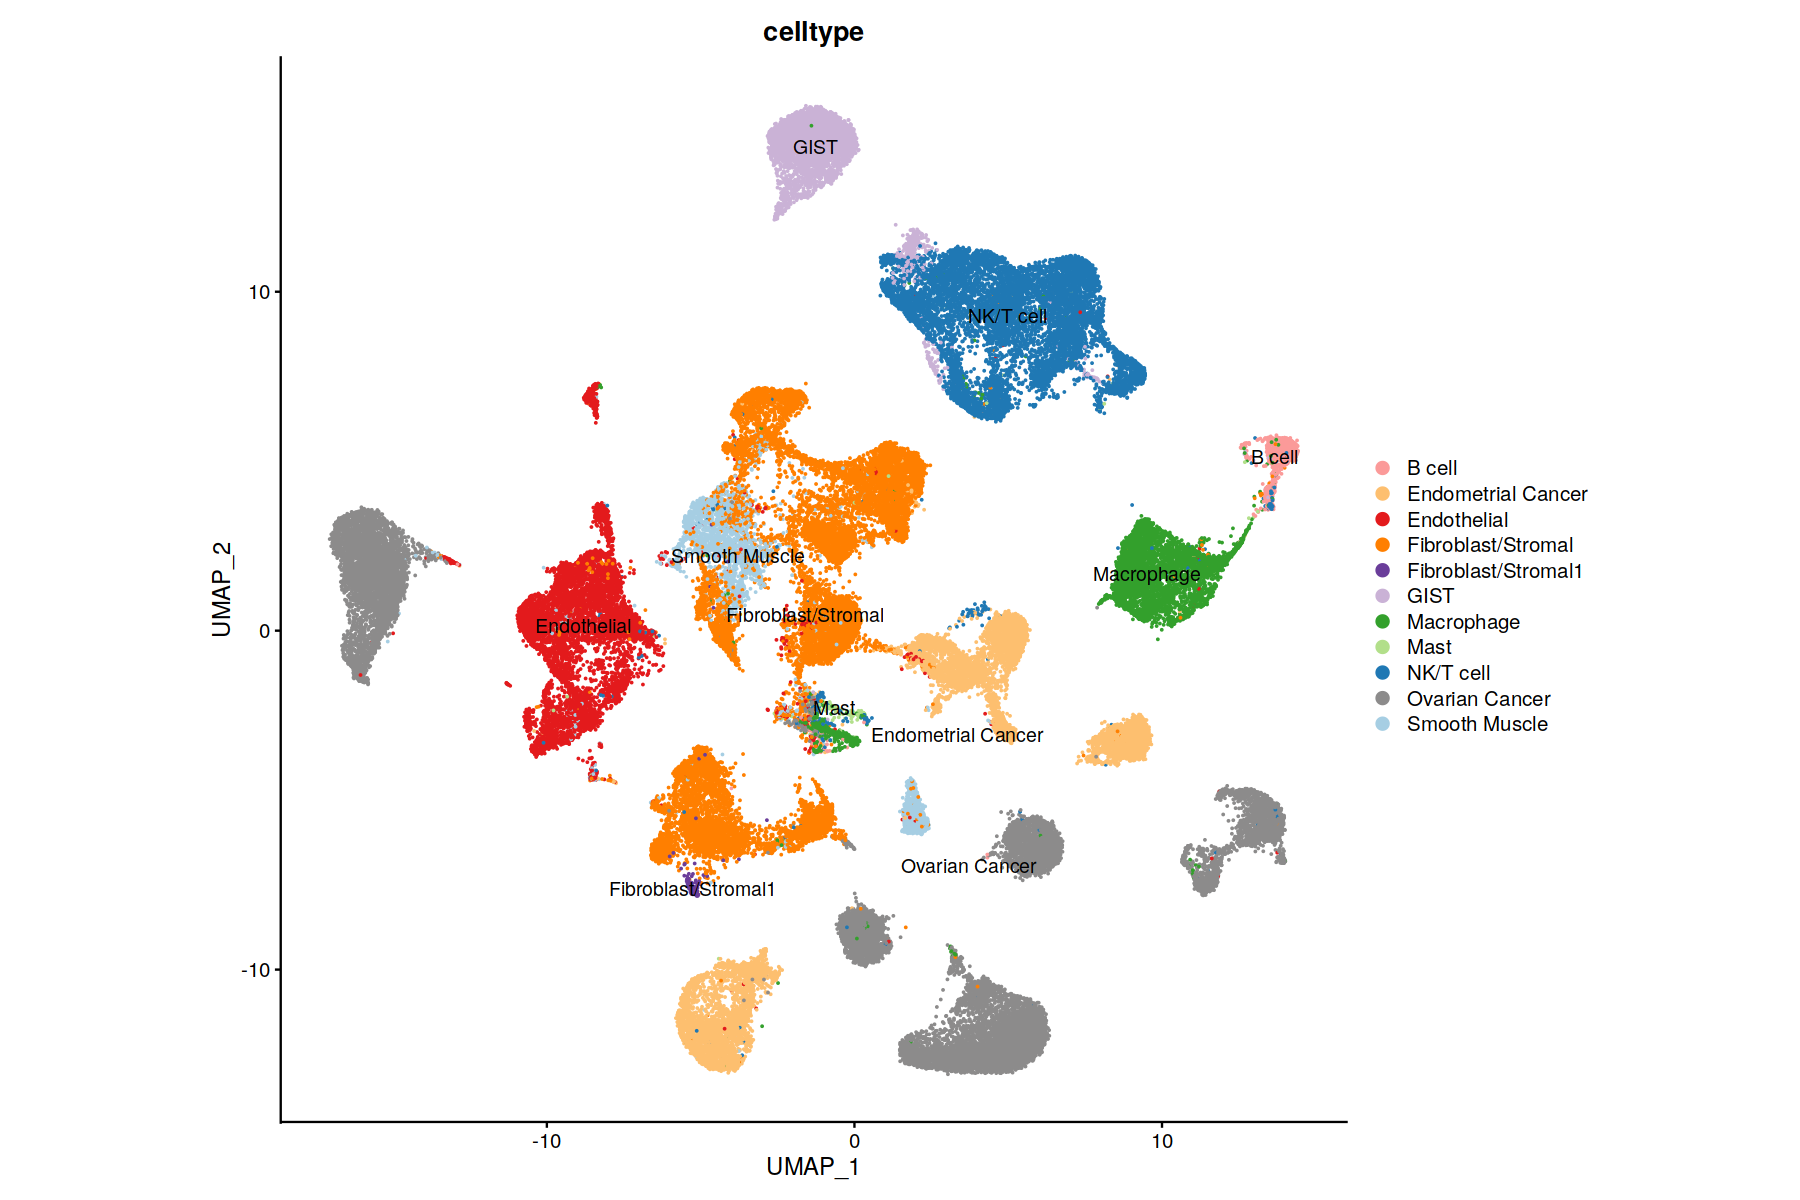

In [206]:
p.umap.label3+scale_color_manual(values=sampleColors)


In [127]:
p.umap.label4 = DimPlot(object = seurat.object,cells = cells.sub, group.by='clusterID',label = TRUE) + 
                theme(aspect.ratio = 1) 

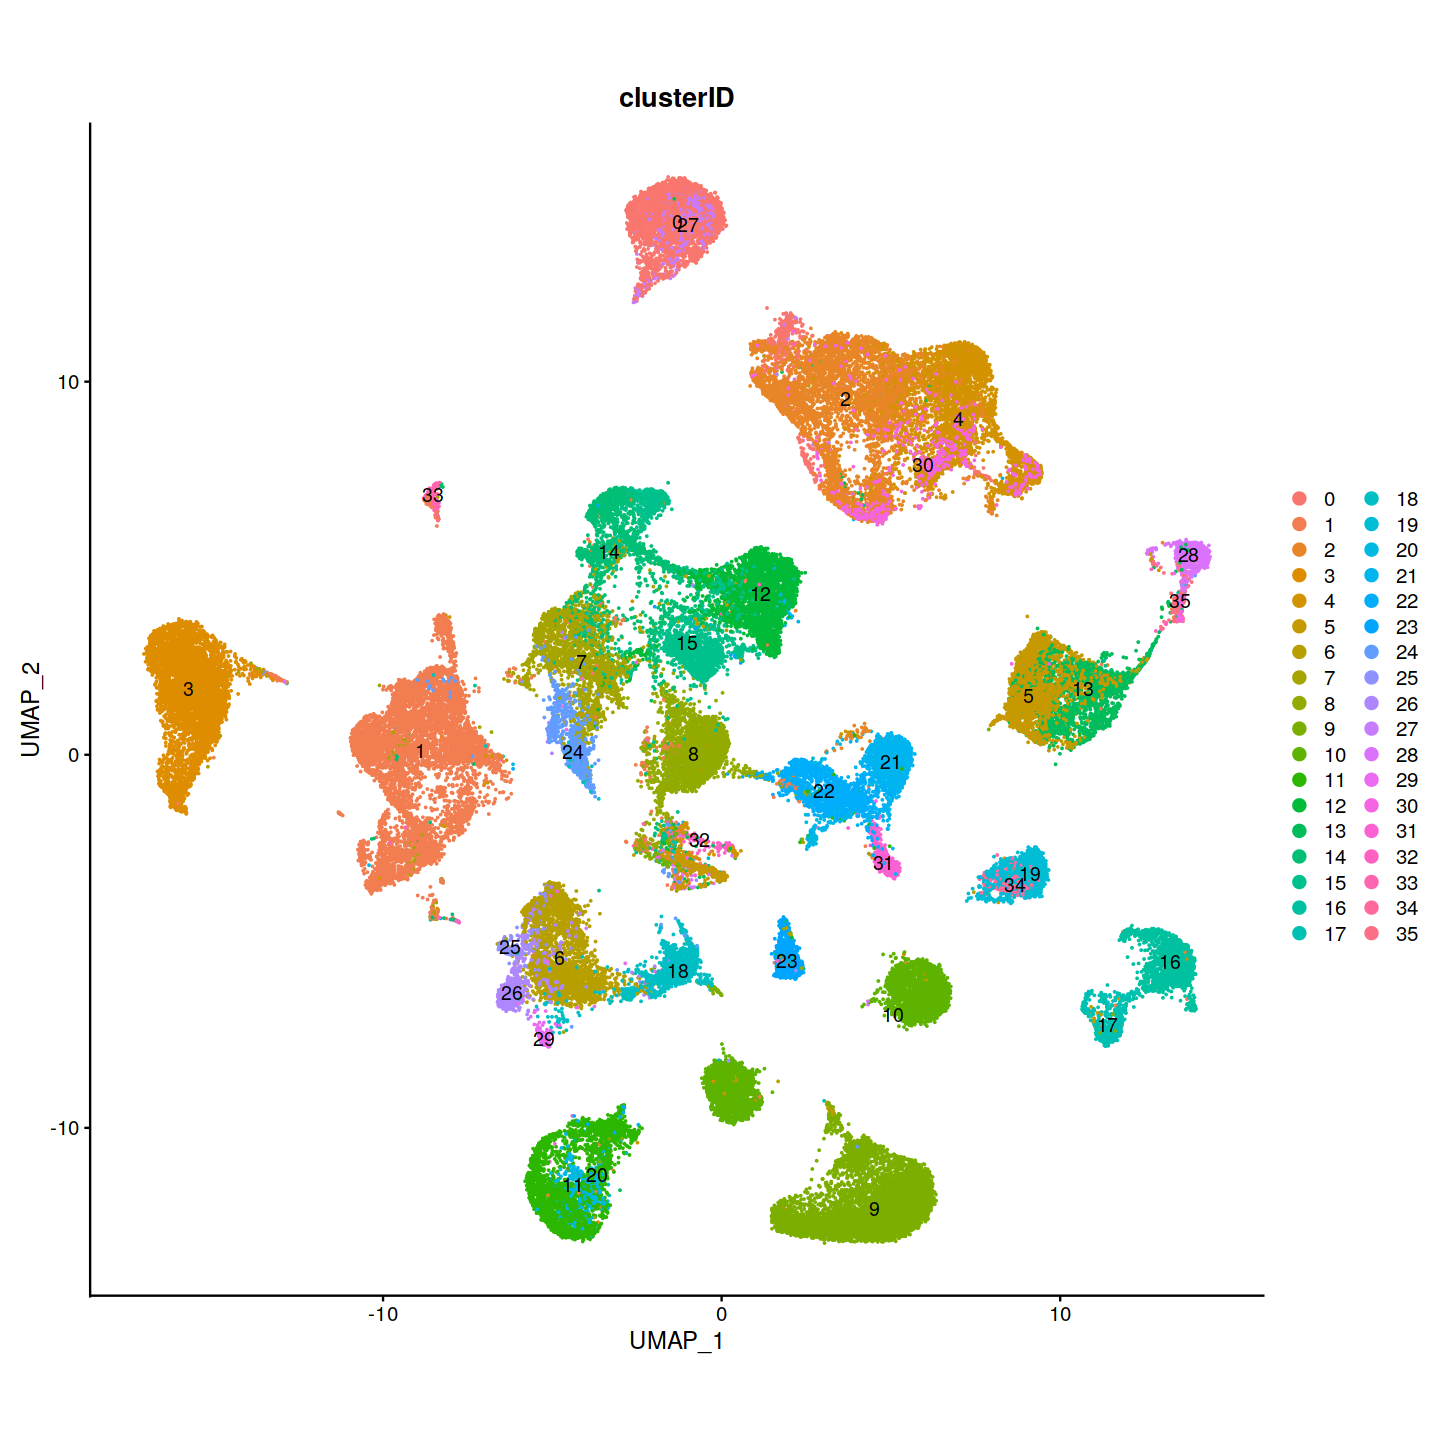

In [128]:
p.umap.label4

In [176]:
DefaultAssay(seurat.object) <- 'RNA'
p.feature.atac = FeaturePlot(seurat.object, features = c('KIT','WFDC2','MUC16'),ncol = 3)#+NoLegend()

p.feature.rna = FeaturePlot(seurat.rna, features = c('KIT','WFDC2','MUC16'),ncol = 3)#+theme(aspect.ratio = 1)

In [177]:
## results
res <- list(metadata.sub = metadata.sub,
            seurat.object=list(atac=seurat.object,rna=seurat.rna), 
            plot=list(p.umap.cluster=p.umap.cluster,
                      p.umap.label=p.umap.label,
                      p.umap.label2=p.umap.label2,
                      p.umap.label3=p.umap.label3,
                      p.umap.label4=p.umap.label4,
                      p.feature.atac=p.feature.atac,
                      p.feature.rna = p.feature.rna,
                      p.umap.cnv=p.umap.cnv,
                      p.umap.cluster.rna=p.umap.cluster.rna,
                      p.umap.label.rna = p.umap.label.rna,
                      p.umap.cnv.rna=p.umap.cnv.rna,
                      p.join = plot.join))
## save all plots
pdf(paste0('plot/','all_more','.pdf'),height = 10,width=30)
(res$plot)%>%print
dev.off()


$p.umap.cluster

$p.umap.label

$p.umap.label2

$p.umap.label3

$p.umap.label4

$p.feature.atac

$p.feature.rna

$p.umap.cnv

$p.umap.cluster.rna

$p.umap.label.rna

$p.umap.cnv.rna

$p.join



png 
  2